In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import TimeSeriesSplit

from lightgbm import LGBMRegressor

In [2]:
### UTILITY FUNCTIONS ###

def smape(true, pred):
    true = np.asarray(true)
    pred = np.asarray(pred)
    return 100 * np.mean(2 * np.abs(true - pred) / (np.abs(true) + np.abs(pred)))


def sim_data(n_samples, n_features, return_coefs=True, random_state=0):
    
    np.random.seed(random_state)
    coefs = np.sin(np.random.normal(0,0.1, (n_samples,n_features)))
    coefs = np.cumsum(coefs, axis=0)

    X = np.random.normal(0,1, (n_samples,n_features))
    y = np.sum(X*coefs, axis=1)
    
    if return_coefs:
        return X, y, coefs
    else:
        return X, y

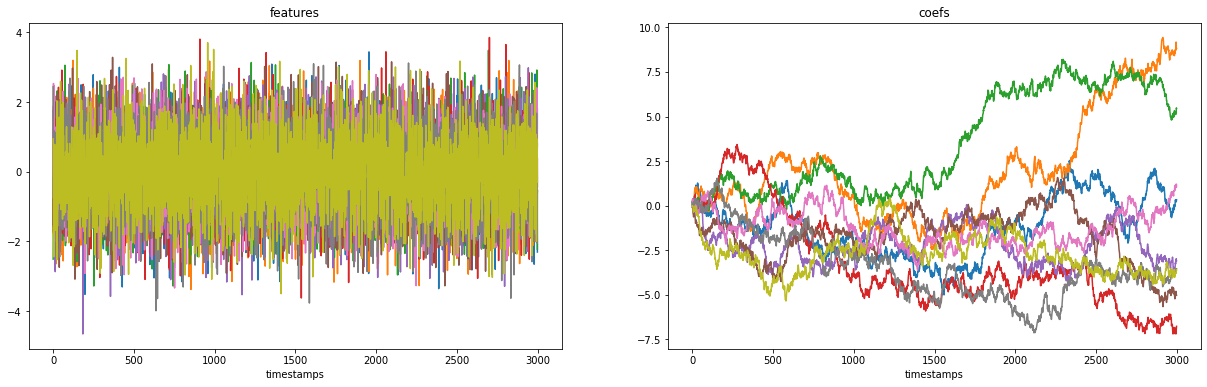

In [3]:
### SIMULATE DATA ###

X, y, coefs = sim_data(n_samples=3000, n_features=9, return_coefs=True, random_state=0)

plt.figure(figsize=(21,6))
plt.subplot(121)
plt.plot(X)
plt.xlabel('timestamps'); plt.title('features')
plt.subplot(122)
plt.plot(coefs)
plt.xlabel('timestamps'); plt.title('coefs')
plt.show()

In [4]:
### SIMULATE MULTIPLE ONLINE FIT WITH SGDRegressor ###

scoresW_ = {}
scoresF_ = {}
scores_ = {}

test_size = 100
CV = TimeSeriesSplit(20, test_size=test_size)

for j in tqdm(range(100)):
    
    _scoresW_ = []
    _scoresF_ = []
    _scores_ = []
    X, y = sim_data(n_samples=3000, n_features=9, return_coefs=False, random_state=j)
    
    for i,(id_train,id_test) in enumerate(CV.split(X)):

        ### stateful ###
        fit_params = {'random_state':33, 'eta0':0.001}
        w = np.linspace(1,10, len(id_train))
        model = SGDRegressor(**fit_params).fit(
            X[id_train], y[id_train], sample_weight=w[id_train]**3
        )
        _scoresW_.append(smape(y[id_test], model.predict(X[id_test])))

        ### continuos ###
        fit_params = {'random_state':33, 'eta0':0.1}
        if i>0:
            previous_model = previous_model.partial_fit( 
                X[id_train[-test_size:]], y[id_train[-test_size:]]
            )
        else:
            previous_model = SGDRegressor(**fit_params).fit(X[id_train], y[id_train])
        _scoresF_.append(smape(y[id_test], previous_model.predict(X[id_test])))

        ### weighted stateful ###
        fit_params = {'random_state':33}
        model = SGDRegressor(**fit_params).fit(X[id_train], y[id_train])
        _scores_.append(smape(y[id_test], model.predict(X[id_test])))
        
    scoresW_[j] = _scoresW_
    scoresF_[j] = _scoresF_
    scores_[j] = _scores_
    
    
scoresW_ = pd.DataFrame(scoresW_).T
scoresF_ = pd.DataFrame(scoresF_).T
scores_ = pd.DataFrame(scores_).T

scoresW_.shape, scoresF_.shape, scores_.shape

100%|██████████| 100/100 [00:21<00:00,  4.74it/s]


((100, 20), (100, 20), (100, 20))

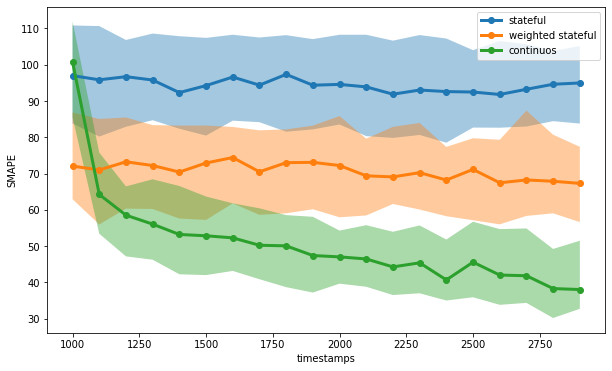

In [5]:
### ERROR COMPARISON ###

refit_range = np.arange(X.shape[0]-CV.n_splits*test_size, X.shape[0], test_size)

plt.figure(figsize=(10,6))
plt.plot(refit_range, scores_.median(), linewidth=3, marker='o', label='stateful')
plt.fill_between(refit_range, scores_.quantile(0.2), scores_.quantile(0.8), alpha=0.4)
plt.plot(refit_range, scoresW_.median(), linewidth=3, marker='o', label='weighted stateful')
plt.fill_between(refit_range, scoresW_.quantile(0.2), scoresW_.quantile(0.8), alpha=0.4)
plt.plot(refit_range, scoresF_.median(), linewidth=3, marker='o', label='continuos')
plt.fill_between(refit_range, scoresF_.quantile(0.2), scoresF_.quantile(0.8), alpha=0.4)
plt.ylabel('SMAPE'); plt.xlabel('timestamps'); plt.legend()

plt.show()

In [6]:
### SIMULATE MULTIPLE ONLINE FIT WITH LGBMRegressor ###

scoresW_ = {}
scoresF_ = {}
scores_ = {}

test_size = 100
CV = TimeSeriesSplit(20, test_size=test_size)

for j in tqdm(range(100)):
    
    _scoresW_ = []
    _scoresF_ = []
    _scores_ = []
    X, y = sim_data(n_samples=3000, n_features=9, return_coefs=False, random_state=j)
    
    for i,(id_train,id_test) in enumerate(CV.split(X)):
        
        fit_params = {'n_estimators':50, 'linear_tree':True, 'random_state':33, 'n_jobs':-1}

        ### refit w/ weigths ###
        w = np.linspace(1,10, len(id_train))
        model = LGBMRegressor(**fit_params).fit(
            X[id_train], y[id_train], sample_weight=w**3
        )
        _scoresW_.append(smape(y[id_test], model.predict(X[id_test])))

        ### online fit ###
        if i>0:
            previous_model = LGBMRegressor(**fit_params).fit(
                X[id_train[-test_size:]], y[id_train[-test_size:]], init_model=previous_model.booster_
            )
        else:
            previous_model = LGBMRegressor(**fit_params).fit(X[id_train], y[id_train])
        _scoresF_.append(smape(y[id_test], previous_model.predict(X[id_test])))

        ### refit ###
        model = LGBMRegressor(**fit_params).fit(X[id_train], y[id_train])
        _scores_.append(smape(y[id_test], model.predict(X[id_test])))
        
    scoresW_[j] = _scoresW_
    scoresF_[j] = _scoresF_
    scores_[j] = _scores_
    
    
scoresW_ = pd.DataFrame(scoresW_).T
scoresF_ = pd.DataFrame(scoresF_).T
scores_ = pd.DataFrame(scores_).T

scoresW_.shape, scoresF_.shape, scores_.shape

100%|██████████| 100/100 [09:05<00:00,  5.45s/it]


((100, 20), (100, 20), (100, 20))

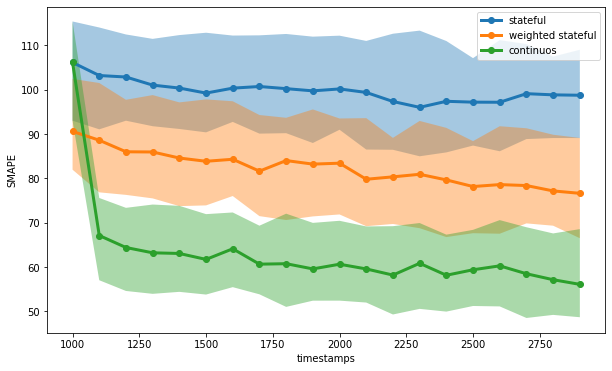

In [7]:
### ERROR COMPARISON ###

refit_range = np.arange(X.shape[0]-CV.n_splits*test_size, X.shape[0], test_size)

plt.figure(figsize=(10,6))
plt.plot(refit_range, scores_.median(), linewidth=3, marker='o', label='stateful')
plt.fill_between(refit_range, scores_.quantile(0.2), scores_.quantile(0.8), alpha=0.4)
plt.plot(refit_range, scoresW_.median(), linewidth=3, marker='o', label='weighted stateful')
plt.fill_between(refit_range, scoresW_.quantile(0.2), scoresW_.quantile(0.8), alpha=0.4)
plt.plot(refit_range, scoresF_.median(), linewidth=3, marker='o', label='continuos')
plt.fill_between(refit_range, scoresF_.quantile(0.2), scoresF_.quantile(0.8), alpha=0.4)
plt.ylabel('SMAPE'); plt.xlabel('timestamps'); plt.legend()

plt.show()